# PCA Normalization of Read Depth

Implement custom principal component analysis of read depth, instead of using xhmm scripts.
Examine which factors correlate wth highest principal components.

In [43]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.linalg

import os
import os
import glob
import re
import pandas
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import seaborn as sns

from hmmlearn import hmm
import scipy.stats
# from sklearn import hmm
%matplotlib inline

In [44]:
# Pre-existing Mean Centred Read Depth Data that has had extreme windows removed
# Each cell in matrix is per-sample per-window read depth.
# Rows are samples, cols are windows.
FILTERED_CENTRED_READ_DEPTH_MAT = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output/xhmm/xhmm_test.filtered_centered.RD.txt"

# GC For all windows across 3D7 genome
# Windows are 298bp, since xHMM requires that there be space between each interval
# Calulated via GATK GCContentByInterval
REF_GC_BY_WINDOW_TSV = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output/xhmm/xhmm_test.locus_GC.txt"

# Windows across genome with extreme read depth that were excluded by xHMM
EXCL_WIN_DEPTH_LIST = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output/xhmm/xhmm_test.PCA_normalized.filtered.sample_zscores.RD.txt.filtered_targets.txt"

# Windows across genome with extreme GC that were excluded by xHMM
EXCL_WIN_GC_LIST = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output/xhmm/xhmm_test.extreme_gc_targets.txt"

# Windows across genome with extreme read depth even after PCA normalization that were excluded by xHMM
EXCL_WIN_PCA_NORM_GC_LIST = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output/xhmm/xhmm_test.PCA_normalized.filtered.sample_zscores.RD.txt.filtered_targets.txt"

# Pysam per position GC and Coverage stats, wildcard pattern
# We are only using the 36 multiplexed swga samples from run 20295 lane 4.
# These have no bead cleanup and were all swga'ed for 16 hours.
PYSAM_GC_STATS_PATTERN = '/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output/pysamstats_gc/{SAMPLE}.*.20295_4_*.{CHROM}.pysamstats_gc.txt'

SAMPLE_WIN_AVE_GC_TSV = '/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output/pysamstats_gc/swga_36plex_noclean_12hr.win_ave.tsv'

# Reference fasta that bams were aligned to
REF_FASTA = '/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/resource/3D7/3D7_V3.fasta'

In [45]:
# with open(FILTERED_CENTRED_READ_DEPTH_MAT) as fh:
#     ncols = len(fh.readline().split("\t")) - 1  # Ignore the first column which lists the sample row names

# nrows_result = ! wc -l { FILTERED_CENTRED_READ_DEPTH_MAT } | tr -s ' ' | cut -f 2 -d " "
# nrows = int(nrows_result[0])-1

# sample_depth_mat = np.loadtxt(FILTERED_CENTRED_READ_DEPTH_MAT, skiprows=1, usecols=range(1,ncols+1))
# sample_depth_mat[:3, :3] 

# Runs PCA on mean-centered data:
#/nfs/team112/tn6/programs/xhmm/statgen-xhmm-cc14e528d909/xhmm --PCA -r $OUTPUT_DIR/xhmm_test.filtered_centered.RD.txt --PCAfiles $OUTPUT_DIR/xhmm_test.RD_PCA

In [46]:
sample_win_depth_df = pandas.read_csv(FILTERED_CENTRED_READ_DEPTH_MAT, sep="\t")
sample_win_depth_df = sample_win_depth_df.rename(columns={"Matrix": "Sample"})
sample_win_depth_df = sample_win_depth_df.set_index("Sample")
display(sample_win_depth_df.shape)
display(sample_win_depth_df.iloc[:, 0:3].head())
display(sample_win_depth_df.iloc[:, 0:3].describe())

(37, 66089)

,Pf3D7_05_v3:27001-27298,Pf3D7_05_v3:27301-27598,Pf3D7_05_v3:27601-27898
Sample,,,
PF1155-CW,-0.630541,1.463784,-16.26973
PF1128-CW,6.449459,8.723784,-8.29973
PF1137-CW,35.259459,72.153784,93.50027
PF1013-CxW,-9.080541,-12.736216,-27.72973
PF1132-CW,-8.500541,-22.816216,-15.42973


,Pf3D7_05_v3:27001-27298,Pf3D7_05_v3:27301-27598,Pf3D7_05_v3:27601-27898
count,3.700000e+01,3.700000e+01,3.700000e+01
mean,5.405402e-10,-3.783784e-09,-2.702701e-10
std,1.617319e+01,3.134085e+01,4.014722e+01
min,-1.278054e+01,-2.862622e+01,-3.435973e+01
25%,-1.096054e+01,-2.159622e+01,-2.717973e+01
50%,-6.530541e+00,-1.323622e+01,-1.298973e+01
75%,6.179459e+00,9.463784e+00,1.096027e+01
max,4.198946e+01,8.562378e+01,1.528403e+02


We only used the 36-multiplexed SWGA samples because they were all processed without bead cleanup,
and processed in the same run and lane.

In [47]:
samples = sample_win_depth_df.index
samples

Index(['PF1155-CW', 'PF1128-CW', 'PF1137-CW', 'PF1013-CxW', 'PF1132-CW',
       'PF1136-CW', 'PF1094-CxW', 'PF1175-CW', 'PF1135-CW', 'PF1051-CxW',
       'PF1092-CxW', 'PF1134-CW', 'PF1131-CW', 'PF1189-CW', 'PF1188-CW',
       'PF1071-CxW', 'PF1118-CW', 'PF1105-CxW', 'PF1010-CxW', 'PF1078-CxW',
       'PF1126-CW', 'PF1018-CxW', 'PF1077-CxW', 'PF1104-CxW', 'PF1119-CW',
       'PF1047-CxW', 'PF1141-CW', 'PF1195-CW', 'PF1075-CxW', 'PF1139-CW',
       'PF1061-CxW', 'PF1170-CW', 'PF1020-CxW', 'PF1089-CxW', 'PF1073-CxW',
       'PF1025-CxW', '3D7_10-T1'],
      dtype='object', name='Sample')

Fraction of variance explained by each principal component

In [48]:
pca = PCA()
pca.fit(sample_win_depth_df)
display(pca.explained_variance_ratio_)

array([  3.51817088e-01,   2.78576362e-01,   9.39533197e-02,
         4.87708868e-02,   3.30899302e-02,   2.64832471e-02,
         1.99651771e-02,   1.77987095e-02,   1.65417418e-02,
         1.44158043e-02,   1.19467908e-02,   1.00872307e-02,
         8.37712626e-03,   7.60763539e-03,   6.75666815e-03,
         5.62839907e-03,   5.25382974e-03,   4.51326220e-03,
         3.75589664e-03,   3.69325074e-03,   3.21561743e-03,
         3.00954326e-03,   2.94296206e-03,   2.68216826e-03,
         2.37313799e-03,   2.18179173e-03,   2.03437166e-03,
         2.01528471e-03,   1.89513456e-03,   1.69077521e-03,
         1.61999991e-03,   1.42708096e-03,   1.21439926e-03,
         1.13303621e-03,   8.14327319e-04,   7.18013034e-04,
         6.93836867e-32])

Variance explained by each principal component

In [49]:
display(pca.explained_variance_)

array([  1.01354357e+08,   8.02545673e+07,   2.70668443e+07,
         1.40503178e+07,   9.53281897e+06,   7.62951143e+06,
         5.75173226e+06,   5.12759847e+06,   4.76548089e+06,
         4.15302336e+06,   3.44172965e+06,   2.90601229e+06,
         2.41335136e+06,   2.19167011e+06,   1.94651648e+06,
         1.62147545e+06,   1.51356644e+06,   1.30021766e+06,
         1.08202956e+06,   1.06398202e+06,   9.26381491e+05,
         8.67013951e+05,   8.47832691e+05,   7.72701069e+05,
         6.83673091e+05,   6.28548488e+05,   5.86078503e+05,
         5.80579779e+05,   5.45965934e+05,   4.87092416e+05,
         4.66702884e+05,   4.11125208e+05,   3.49854116e+05,
         3.26414380e+05,   2.34598105e+05,   2.06851094e+05,
         1.99886225e-23])

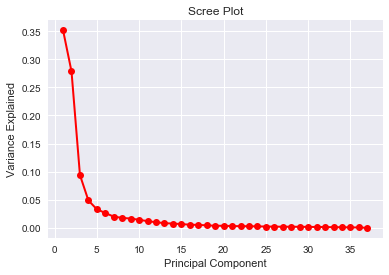

In [50]:
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

## Correlations of Principal Components to Possible Explanatory Features

In [51]:
# Principal components are a linear combination of the features.  In our case, the features are window depths.
# Does the contribution of the window depth to the principal component correlate to the window's GC?
pca.components_.shape

(37, 66089)

In [52]:
display(pca.components_[:2, :10])

array([[ 0.00018042,  0.00022412,  0.00036372,  0.00033599,  0.00029813,
         0.00038533,  0.00148819, -0.00029201, -0.00046609, -0.00016933],
       [ 0.00060617,  0.00018578,  0.00022649,  0.00016808,  0.00080998,
         0.00057675,  0.00015348,  0.00018529,  0.00017979,  0.00092887]])

In [53]:
ref_gc_by_win = pandas.read_csv(REF_GC_BY_WINDOW_TSV, sep="\t", header=None)
ref_gc_by_win.columns = ["window", "gc"]
ref_gc_by_win = ref_gc_by_win.set_index("window")
display(ref_gc_by_win.head())
display(ref_gc_by_win.describe())
display(ref_gc_by_win.shape)

,gc
window,
Pf3D7_05_v3:1-298,0.473154
Pf3D7_05_v3:301-598,0.392617
Pf3D7_05_v3:601-898,0.278523
Pf3D7_05_v3:901-1198,0.265101
Pf3D7_05_v3:1201-1498,0.322148


,gc
count,77785.000000
mean,0.193423
std,0.068125
min,0.000000
25%,0.144295
50%,0.187919
75%,0.231544
max,0.617450


(77785, 1)

In [54]:
# # Remove the windows with extreme read depth that are excluded by xHMM
# excl_win_cuz_depth = np.genfromtxt(EXCL_WIN_DEPTH_LIST, dtype='str')
# display(excl_win_cuz_depth.shape)
# display(excl_win_cuz_depth[:10])

In [55]:
# # Remove the windows with extreme GC that are excluded by xHMM
# excl_win_cuz_gc = np.genfromtxt(EXCL_WIN_GC_LIST, dtype='str')
# display(excl_win_cuz_gc.shape)
# display(excl_win_cuz_gc[:10])

In [56]:
# # Remove the windows with extreme GC after PC normalization that are excluded by xHMM
# excl_win_cuz_pc_norm_gc = np.genfromtxt(EXCL_WIN_PCA_NORM_GC_LIST, dtype='str')
# display(excl_win_cuz_pc_norm_gc.shape)
# display(excl_win_cuz_pc_norm_gc[:10])

In [57]:
# filt_ref_gc_by_win = ref_gc_by_win.drop(excl_win_cuz_depth, axis="index")
# filt_ref_gc_by_win = filt_ref_gc_by_win.drop(excl_win_cuz_gc, axis="index")
# filt_ref_gc_by_win = filt_ref_gc_by_win.drop(excl_win_cuz_pc_norm_gc, axis="index", errors="ignore")
# display(filt_ref_gc_by_win.shape)
# display(filt_ref_gc_by_win.head())
# display(filt_ref_gc_by_win.describe())

In [58]:
# Double check that we have the same total filtered targets as the xhmm principal component dataset file.

PC_TSV = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output/xhmm/xhmm_test.RD_PCA.PC.txt"

# Show what header looks like
! head -1  { PC_TSV }  | tr "\t" "\n" | head -3

V_T
Pf3D7_05_v3:27001-27298
Pf3D7_05_v3:27301-27598


In [59]:
# Count the total target header columns
! head -1  { PC_TSV }  | tr "\t" "\n" | tail -n +2 | wc -l

   66089


In [60]:
# That's not working.  Try to filter without using the exclusion files 
# because they are obviously missing targets that are excluded 
# in the xhmm output for filtered mean-centred read depths
ref_gc_by_win = ref_gc_by_win.reset_index()
filt_ref_gc_by_win = ref_gc_by_win[ref_gc_by_win["window"].isin(sample_win_depth_df.columns)]
filt_ref_gc_by_win = filt_ref_gc_by_win.set_index("window")
display(filt_ref_gc_by_win.shape)
display(filt_ref_gc_by_win.head())
display(filt_ref_gc_by_win.describe())

(66089, 1)

,gc
window,
Pf3D7_05_v3:27001-27298,0.224832
Pf3D7_05_v3:27301-27598,0.338926
Pf3D7_05_v3:27601-27898,0.231544
Pf3D7_05_v3:27901-28198,0.342282
Pf3D7_05_v3:28201-28498,0.244966


,gc
count,66089.000000
mean,0.191561
std,0.053259
min,0.100671
25%,0.151007
50%,0.187919
75%,0.224832
max,0.503356


In [61]:
# # Find the difference between each window GC and the mean GC across all windows 
# display(filt_ref_gc_by_win.shape)
# dist_gc_from_mean = filt_ref_gc_by_win - filt_ref_gc_by_win.mean()
# display(dist_gc_from_mean.shape)
# display(dist_gc_from_mean[:3])

In [62]:
# # For every PC, find the difference between the PC feature coefficients and the mean feature coefficient across PCs
# # If our PC matrix is n x m; n total PC's, m features,
# # then the matrix of means is shaped 1 x m
# # then final differences matrix is shaped n x m
# display(pca.components_.shape)  # pca components shape is  n PCs x m features
# ave_coeff_per_pc = pca.components_.mean(axis=0)  # shape is 1 x m features
# display(ave_coeff_per_pc)
# display(ave_coeff_per_pc.shape)
# dist_pc_from_mean = pca.components_ - ave_coeff_per_pc  # shape is n PCs x m features
# display(dist_pc_from_mean.shape)
# display(dist_pc_from_mean[:4, :3])

In [63]:
# # Find the correlation between pc's and gc
# total_features = filt_ref_gc_by_win.shape[0]

# # From https://stackoverflow.com/questions/48105922/numpy-covariance-between-each-column-of-a-matrix-and-a-vector?noredirect=1&lq=1
# # Each element in the PC vector are the contributions of each window (features)
# # For each PC vector, how do contributions of each window correlate to GC.
# # If n PCs, and m features,
# # We find the dot product of matrix:  1 x m  dot  m x n  = 1 x n
# cov = np.dot(dist_gc_from_mean.transpose(), dist_pc_from_mean.transpose()) / (total_features-1)  # 1 x n
# display(cov.shape)
# display(cov)

# var_gc = np.var(filt_ref_gc_by_win, ddof=1)  # 1 x 1
# display(var_gc.shape)
# display(var_gc)

# var_pc = np.var(pca.components_, axis=1, ddof=1)  # 1 x n
# display(var_pc.shape)
# display(var_pc)


# # ??? If we dno't use np.array(), then we get error " Wrong number of items passed 37, placement implies 1"
# # But we can't keep the dimensions either, in np.var because it's unaccepted as a keyword.
# corr =   cov / np.sqrt(np.array(var_gc) * var_pc)  # 1 x n
# display(corr.shape)
# display(corr)

In [64]:
# # That is odd that the first few principal components are slightly negatively correlated with GC.  
# # In the xHMM tutorial, they found that the absolute value of the correlation is ~ 0.6 for the intial PCs.

# # Double check with the xHMM output PCs have similar values to our calculated PCs
# xhmm_pc = pandas.read_csv(PC_TSV, sep="\t")
# xhmm_pc = xhmm_pc.set_index("V_T")
# display(xhmm_pc.shape)
# display(xhmm_pc.iloc[:3, :3].head())
# display(xhmm_pc.iloc[:3, :3].describe())

In [65]:
# diff_np_xhmm_pc = pca.components_ - xhmm_pc
# display(diff_np_xhmm_pc.shape)
# display(diff_np_xhmm_pc.iloc[:3, :3].head())
# display(diff_np_xhmm_pc.iloc[:3, :3].describe())

In [66]:
# # Find which target names differ from the filtered read depth matrix and the 

# # For every PC, find the difference between the PC feature coefficients and the mean feature coefficient across PCs
# # If our PC matrix is n x m; n total PC's, m features,
# # then the matrix of means is shaped 1 x m
# # then final differences matrix is shaped n x m
# display(xhmm_pc.shape)  # pca components shape is  n PCs x m features
# ave_coeff_per_xhmm_pc = xhmm_pc.mean(axis=0)  # shape is 1 x m features
# display(ave_coeff_per_xhmm_pc.head())
# display(ave_coeff_per_xhmm_pc.shape)
# dist_xhmm_pc_from_mean = xhmm_pc - ave_coeff_per_xhmm_pc  # shape is n PCs x m features
# display(dist_xhmm_pc_from_mean.shape)
# display(dist_xhmm_pc_from_mean.iloc[:4, :3])

In [67]:
# # From https://stackoverflow.com/questions/48105922/numpy-covariance-between-each-column-of-a-matrix-and-a-vector?noredirect=1&lq=1
# # Each element in the PC vector are the contributions of each window (features)
# # For each PC vector, how do contributions of each window correlate to GC.
# # If n PCs, and m features,
# # We find the dot product of matrix:  1 x m  dot  m x n  = 1 x n
# xhmm_cov = np.dot(dist_gc_from_mean.transpose(), dist_xhmm_pc_from_mean.transpose()) / (total_features-1)  # 1 x n
# display(xhmm_cov.shape)
# display(xhmm_cov)

# var_xhmm_pc = xhmm_pc.var(axis=1, ddof=1)  # 1 x n
# display(var_xhmm_pc.as_matrix().shape)
# display(var_xhmm_pc.as_matrix())

# # corr = cov / np.sqrt(var_dist_gc_from_mean * var_dist_pc_from_mean)  # 1 x n
# # ??? If we don't use np.array(), then we get error " Wrong number of items passed 37, placement implies 1"
# # But we can't keep the dimensions either, in np.var because it's unaccepted as a keyword.
# var_mult = np.array(var_gc) * var_xhmm_pc.as_matrix()
# display(var_mult.shape)
# xhmm_corr =   xhmm_cov / np.sqrt(np.array(var_gc) * var_xhmm_pc.as_matrix())  # 1 x n
# display(xhmm_corr.shape)
# display(xhmm_corr)

In [68]:
# # Plot correlations between GC and xhmm principal components
# plt.plot(range(1, pca.components_.shape[0]+1), np.ndarray.flatten(xhmm_corr))
# plt.title("Correlation")

In [69]:
# Find the difference between each window mean read depth and the mean read depth across all windows 
# display(sample_win_depth_df.shape)
# sample_win_depth_df
# dist_win_depth_from_mean = sample_win_depth_df.transpose().subtract(sample_win_depth_df.mean(axis=1))
# display(dist_depth_from_mean.shape)
# display(dist_depth_from_mean[:3])

In [70]:
# A = m x n matrix
# b = m x 1 matrix
# Ie m observations, n replicates of each set of m observations
# Find the covariance between the columns of A and the vector b
# cov (col of A, b) = (b transpose - mean b) dot (A - colmean A) / (m-1)
# See https://stackoverflow.com/questions/48105922/numpy-covariance-between-each-column-of-a-matrix-and-a-vector?noredirect=1&lq=1
def colcov(A, b):
    m = A.shape[0]
    
    diff_b_mean_b = b - b.mean(axis=0)
    diff_A_mean_A = A - A.mean(axis=0)
    return np.dot(diff_b_mean_b.transpose(), diff_A_mean_A) / (m - 1)


def colcorr(A, b):
    """
    A is numpy 2D matrix
    b is numpy array
    """
    
    cov = colcov(A,b)

    var_b_x_var_A = np.asscalar(np.var(b, axis=0, ddof=1)) * np.var(A, axis=0, ddof=1, keepdims=True) 

    corr = cov / np.sqrt(var_b_x_var_A) 
    return corr
    

(37,)

(37, 1)

(37, 66089)

(37, 66089)

,Pf3D7_05_v3:27001-27298,Pf3D7_05_v3:27301-27598,Pf3D7_05_v3:27601-27898,Pf3D7_05_v3:27901-28198,Pf3D7_05_v3:28201-28498,Pf3D7_05_v3:28501-28798,Pf3D7_05_v3:29101-29398,Pf3D7_05_v3:30601-30898,Pf3D7_05_v3:33601-33898,Pf3D7_05_v3:36301-36598,...,PFC10_API_IRAB:19201-19498,PFC10_API_IRAB:19501-19798,PFC10_API_IRAB:19801-20098,PFC10_API_IRAB:20101-20398,PFC10_API_IRAB:20401-20698,PFC10_API_IRAB:21001-21298,PFC10_API_IRAB:21301-21598,PFC10_API_IRAB:25801-26098,PFC10_API_IRAB:26101-26398,PFC10_API_IRAB:27001-27298
0,1.816365,2.256282,3.661736,3.382589,3.001447,3.879316,14.982364,-2.939794,-4.692370,-1.704688,...,-8.433958,-9.083979,-8.922022,-8.837927,-7.626305,-3.510024,-3.797796,-4.300288,-3.562291,-3.935604
1,5.430406,1.664289,2.029012,1.505716,7.256232,5.166784,1.374975,1.659922,1.610624,8.321250,...,7.721418,7.630531,7.167380,5.800202,5.208861,8.412177,9.219300,3.132744,4.560649,3.537066
2,6.599087,9.322422,11.636936,7.632433,7.475841,5.684412,14.387243,1.334181,2.250627,8.348187,...,6.504170,5.982885,5.565573,5.780135,5.768386,9.057041,9.877397,8.632207,6.788981,3.549605
3,3.474816,11.239264,12.691478,7.870343,2.732328,0.489852,9.503883,-2.062078,0.389535,1.450872,...,-3.446690,-3.332204,-3.378150,-2.970004,-2.730267,-5.607916,-6.945640,-2.167484,-2.602487,0.115741
4,2.874021,4.507425,5.555514,-1.281428,-2.352848,-3.494041,-11.387458,-1.161730,-2.815863,-3.335667,...,-1.824238,-0.856852,-0.825034,-1.357016,-1.233739,-0.869084,-0.987164,-2.632044,-1.050302,-1.282558


(37, 66089)

,Pf3D7_05_v3:27001-27298,Pf3D7_05_v3:27301-27598,Pf3D7_05_v3:27601-27898,Pf3D7_05_v3:27901-28198,Pf3D7_05_v3:28201-28498,Pf3D7_05_v3:28501-28798,Pf3D7_05_v3:29101-29398,Pf3D7_05_v3:30601-30898,Pf3D7_05_v3:33601-33898,Pf3D7_05_v3:36301-36598,...,PFC10_API_IRAB:19201-19498,PFC10_API_IRAB:19501-19798,PFC10_API_IRAB:19801-20098,PFC10_API_IRAB:20101-20398,PFC10_API_IRAB:20401-20698,PFC10_API_IRAB:21001-21298,PFC10_API_IRAB:21301-21598,PFC10_API_IRAB:25801-26098,PFC10_API_IRAB:26101-26398,PFC10_API_IRAB:27001-27298
0,-0.630541,1.463784,-16.26973,-14.056486,-5.444324,-5.871622,-27.254324,-7.521351,-4.813784,-2.188919,...,-6.763784,-5.025676,-3.266486,-3.487568,-4.899459,0.81973,-3.711892,-8.201351,-3.109189,-3.425676
1,6.449459,8.723784,-8.29973,-10.236486,3.355676,-7.481622,-7.674324,-6.071351,5.236216,35.351081,...,-10.223784,-4.505676,-7.206486,-3.887568,-4.549459,-4.61027,-5.371892,-5.391351,-5.409189,-7.025676
2,35.259459,72.153784,93.50027,48.523514,13.515676,-8.391622,-24.274324,-8.031351,-8.723784,2.401081,...,-15.733784,-14.285676,-13.846486,-11.977568,-8.869459,-5.37027,-7.501892,-2.331351,-0.619189,-6.275676
3,-9.080541,-12.736216,-27.72973,-14.646486,-12.164324,-11.821622,-25.804324,-10.151351,-9.983784,-10.288919,...,-18.373784,-15.465676,-15.366486,-15.467568,-14.979459,-13.41027,-16.011892,-17.461351,-12.119189,-10.155676
4,-8.500541,-22.816216,-15.42973,-16.326486,-13.244324,19.918378,29.695676,-10.271351,-10.253784,-10.288919,...,-3.563784,-5.255676,-4.706486,-6.637568,-4.439459,1.93973,14.338108,-3.981351,-4.769189,-3.715676


(37,)

0    -0.653075
1    -0.527060
2     0.582499
3     0.065254
4    -0.018004
5    -0.017841
6    -0.012387
7    -0.024373
8     0.067261
9    -0.034378
10    0.097620
11    0.081019
12    0.156106
13   -0.004027
14   -0.134526
15   -0.121454
16    0.059023
17   -0.049732
18    0.022409
19    0.004225
20   -0.069725
21   -0.025082
22   -0.012725
23    0.035325
24   -0.116864
25    0.056459
26    0.011011
27    0.002621
28    0.002296
29   -0.008803
30    0.005248
31    0.005792
32    0.003577
33   -0.038040
34   -0.001982
35    0.116803
36    0.003308
dtype: float64

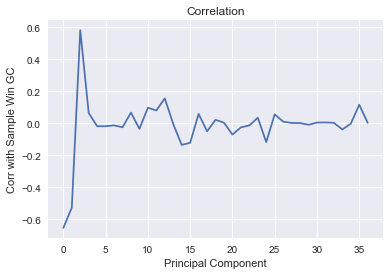

In [71]:
# Convert (37,) vector to (37, 1) matrix
display(pca.explained_variance_.shape)
explained_stdev_2d = np.reshape(np.sqrt(pca.explained_variance_), (len(pca.explained_variance_), 1))
display(explained_stdev_2d.shape)
loadings = explained_stdev_2d *  pca.components_  # elementwise multiply
display(loadings.shape)

loadings_df = pandas.DataFrame(loadings, columns=sample_win_depth_df.columns)
display(loadings_df.shape) 
display(loadings_df.head())

sample_win_depth_df_no_samp_name = sample_win_depth_df.reset_index().drop(["Sample"], axis=1)
display(sample_win_depth_df_no_samp_name.shape)
display(sample_win_depth_df_no_samp_name.head())


# Find correlation of each window contribution to PC vs each window depth for each principal component
# We should end up with a correlation coefficient value for each of the 37 principal components.

# TODO: is this valid?  Are each principal components just a loading of a single sample and just a single window?
# Or is an element of a principal component a projection of every sample and just a single window?


# Only cols with same name will be compared:  https://stackoverflow.com/questions/46041148/pandas-corr-vs-corrwith?rq=1
corr_sample_win_gc_pc = loadings_df.corrwith(sample_win_depth_df_no_samp_name, axis=1)
display(corr_sample_win_gc_pc.shape)
display(corr_sample_win_gc_pc)

plt.plot(range(0, pca.components_.shape[0]), corr_sample_win_gc_pc)
plt.title("Correlation")
plt.xlabel("Principal Component")
plt.ylabel("Corr with Sample Win GC")

In [72]:
display(filt_ref_gc_by_win.shape)
display(pca.components_.shape) 
# Find correlation of each window contribution to PC vs each window Ref GC for each principal component
# We should end up with a correlation coefficient value for each of the 37 principal components.
corr_ref_gc_pc = colcorr(A=loadings_df.transpose().as_matrix(), b=filt_ref_gc_by_win)
display(corr_ref_gc_pc.shape)
display(corr_ref_gc_pc)

(66089, 1)

(37, 66089)

(1, 37)

array([[-0.33824366, -0.24665945, -0.12607351,  0.23431759,  0.00665429,
         0.03499796,  0.06666654, -0.09233407,  0.02925108,  0.09290307,
         0.05454314,  0.05250044, -0.0396498 , -0.01732505, -0.01959041,
        -0.00514168, -0.02887469, -0.07659822, -0.13117289,  0.04731225,
        -0.06951222, -0.09232149,  0.08915409,  0.10995253, -0.02350354,
        -0.05389248,  0.0466914 , -0.04800744,  0.02346501,  0.0031751 ,
        -0.07444569, -0.04477329,  0.01802156, -0.00358574, -0.03128201,
         0.07018197, -0.00338507]])

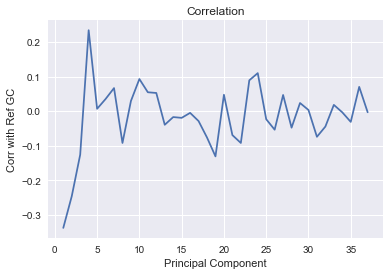

In [73]:
# Plot correlations between Ref GC and principal components
plt.plot(range(1, pca.components_.shape[0]+1), np.ndarray.flatten(corr_ref_gc_pc))
plt.title("Correlation")
plt.xlabel("Principal Component")
plt.ylabel("Corr with Ref GC")

In [74]:
# Find correlation between target mean GC and Principal Component


# The pysam stats are stored on disk, split by sample and chromosome.

def get_win_ave_gc(pysam_gc_stats_tsv_pattern, samples, chroms):
    """
    For each window, find the average read depth across samples.
    """
    is_stop = False
    prev_pysam_by_win = pandas.DataFrame()

    for i, chrom in enumerate(chroms):
        for j, sample in enumerate(samples):
            filled_pysam_gc_stats_tsv_pattern = pysam_gc_stats_tsv_pattern.replace("{SAMPLE}", sample)
            filled_pysam_gc_stats_tsv_pattern = filled_pysam_gc_stats_tsv_pattern.replace("{CHROM}", chrom)
            
            for pysam_gc_stats_tsv in glob.glob(filled_pysam_gc_stats_tsv_pattern):
                display(pysam_gc_stats_tsv)
                # Per-position GC content, read coverage.  
                # We don't care about properly paired reads here, since there could be 
                # inversions, deletions, insertions that alter orientation of read pairs.
                pysam_gc = pandas.read_csv(pysam_gc_stats_tsv, sep="\t")
                # Indicate the window start position
                pysam_gc["window"] =  300 * (pysam_gc.pos // 300)

                # Aggregate gc, reads by window.  Weighted average because end windows might be < 300bp.
                # In order to avoid having all pysamstats from all chromosomes in memory,
                # we do a running weighted average.

                pysam_by_win = pysam_gc.groupby(["chrom", "window"]).agg({
                    'gc': {'gc_win_mean': 'mean'},
                    'reads_all': {'reads_all_win_mean': "mean"},
                    'pos': {"win_size": "count"}
                })
                pysam_by_win.columns = pysam_by_win.columns.droplevel()
                pysam_by_win["gc_x_win_size"] = pysam_by_win["gc_win_mean"] * pysam_by_win["win_size"]
                pysam_by_win["reads_x_win_size"] = pysam_by_win["reads_all_win_mean"] * pysam_by_win["win_size"]
                
#                 display(pysam_by_win.shape)
#                 display(pysam_by_win.head())
                
                if prev_pysam_by_win.shape[0]:
                    pysam_by_win = pysam_by_win.add(prev_pysam_by_win, axis="index", fill_value=0)

#                 display(pysam_by_win.shape)
#                 display(pysam_by_win.head())

                prev_pysam_by_win = pysam_by_win
                
                
#             if j > 2:
#                 break
#         if i > 2:
#             break
            
        
        
    pysam_by_win["weighted_gc_win_mean"] = pysam_by_win["gc_x_win_size"] / pysam_by_win["win_size"]
    
    return pysam_by_win

In [75]:
import Bio.SeqIO as SeqIO

chroms = []
for record in SeqIO.parse(REF_FASTA, "fasta"):
    chroms.append(record.id)
chroms


['Pf3D7_05_v3',
 'Pf3D7_10_v3',
 'Pf3D7_07_v3',
 'Pf3D7_03_v3',
 'Pf3D7_13_v3',
 'Pf3D7_11_v3',
 'Pf3D7_14_v3',
 'Pf3D7_09_v3',
 'Pf3D7_01_v3',
 'Pf3D7_12_v3',
 'Pf3D7_08_v3',
 'Pf3D7_06_v3',
 'Pf3D7_04_v3',
 'Pf3D7_02_v3',
 'M76611',
 'PFC10_API_IRAB']

In [76]:
if os.path.exists(SAMPLE_WIN_AVE_GC_TSV):
    win_ave = pandas.read_csv(SAMPLE_WIN_AVE_GC_TSV, sep="\t")
    win_ave = win_ave.set_index(["chrom", "window"])
else:
    win_ave = get_win_ave_gc(pysam_gc_stats_tsv_pattern=PYSAM_GC_STATS_PATTERN, 
                samples=samples, chroms=chroms)
display(win_ave.shape)
display(win_ave.head())

(77303, 6)

win_size  reads_all_win_mean  gc_win_mean  gc_x_win_size  \
chrom  window                                                             
M76611 0         7029.0          143.110720  1063.255599       257208.0   
       300       8647.0          179.017450  1171.860174       327467.0   
       600       8766.0          173.270242   880.462466       240010.0   
       900       8610.0          183.224231   709.035065       203515.0   
       1200      8992.0          200.435344   815.556972       228699.0   

               reads_x_win_size  weighted_gc_win_mean  
chrom  window                                          
M76611 0                37409.0             36.592403  
       300              52867.0             37.870591  
       600              50924.0             27.379649  
       900              54412.0             23.637050  
       1200             59394.0             25.433608

In [77]:
if not os.path.exists(SAMPLE_WIN_AVE_GC_TSV):
    win_ave.to_csv(SAMPLE_WIN_AVE_GC_TSV, sep="\t", index=True)

In [78]:
display(loadings_df.shape) 
display(loadings_df.head())

# Convert xhmm targets to windows
win_loadings = loadings_df.transpose()
win_loadings.columns = ["PC" + str(col) for col in win_loadings.columns]
win_loadings.index.name = "target"
win_loadings = win_loadings.reset_index()
win_loadings['chrom'], win_loadings['target_range'] = win_loadings['target'].str.split(':', 1).str
win_loadings['target_start'], win_loadings['target_end'] = win_loadings['target_range'].str.split('-', 1).str
win_loadings['target_start'] = pandas.to_numeric(win_loadings['target_start'])
win_loadings["window"] =  300 * (win_loadings.target_start // 300)
win_loadings = win_loadings.drop(["target", "target_range", "target_start", "target_end"], axis=1)
win_loadings = win_loadings.set_index(["chrom", "window"])
display(win_loadings.head())

display(win_ave.shape)
# create an empty dataframe with just the index from the loading targets
# so that when we join, we don't get extra columns in filt_win_ave
filt_win_ave = win_ave.join(pandas.DataFrame(index=win_loadings.index.copy()), how="right")
display(filt_win_ave.shape)
display(filt_win_ave.head())


(37, 66089)

,Pf3D7_05_v3:27001-27298,Pf3D7_05_v3:27301-27598,Pf3D7_05_v3:27601-27898,Pf3D7_05_v3:27901-28198,Pf3D7_05_v3:28201-28498,Pf3D7_05_v3:28501-28798,Pf3D7_05_v3:29101-29398,Pf3D7_05_v3:30601-30898,Pf3D7_05_v3:33601-33898,Pf3D7_05_v3:36301-36598,...,PFC10_API_IRAB:19201-19498,PFC10_API_IRAB:19501-19798,PFC10_API_IRAB:19801-20098,PFC10_API_IRAB:20101-20398,PFC10_API_IRAB:20401-20698,PFC10_API_IRAB:21001-21298,PFC10_API_IRAB:21301-21598,PFC10_API_IRAB:25801-26098,PFC10_API_IRAB:26101-26398,PFC10_API_IRAB:27001-27298
0,1.816365,2.256282,3.661736,3.382589,3.001447,3.879316,14.982364,-2.939794,-4.692370,-1.704688,...,-8.433958,-9.083979,-8.922022,-8.837927,-7.626305,-3.510024,-3.797796,-4.300288,-3.562291,-3.935604
1,5.430406,1.664289,2.029012,1.505716,7.256232,5.166784,1.374975,1.659922,1.610624,8.321250,...,7.721418,7.630531,7.167380,5.800202,5.208861,8.412177,9.219300,3.132744,4.560649,3.537066
2,6.599087,9.322422,11.636936,7.632433,7.475841,5.684412,14.387243,1.334181,2.250627,8.348187,...,6.504170,5.982885,5.565573,5.780135,5.768386,9.057041,9.877397,8.632207,6.788981,3.549605
3,3.474816,11.239264,12.691478,7.870343,2.732328,0.489852,9.503883,-2.062078,0.389535,1.450872,...,-3.446690,-3.332204,-3.378150,-2.970004,-2.730267,-5.607916,-6.945640,-2.167484,-2.602487,0.115741
4,2.874021,4.507425,5.555514,-1.281428,-2.352848,-3.494041,-11.387458,-1.161730,-2.815863,-3.335667,...,-1.824238,-0.856852,-0.825034,-1.357016,-1.233739,-0.869084,-0.987164,-2.632044,-1.050302,-1.282558


PC0       PC1        PC2        PC3       PC4  \
chrom       window                                                       
Pf3D7_05_v3 27000   1.816365  5.430406   6.599087   3.474816  2.874021   
            27300   2.256282  1.664289   9.322422  11.239264  4.507425   
            27600   3.661736  2.029012  11.636936  12.691478  5.555514   
            27900   3.382589  1.505716   7.632433   7.870343 -1.281428   
            28200   3.001447  7.256232   7.475841   2.732328 -2.352848   

                         PC5       PC6       PC7       PC8       PC9  \
chrom       window                                                     
Pf3D7_05_v3 27000   0.765310 -2.688514 -2.727811  0.309331  0.892793   
            27300   0.199382 -4.452174 -5.959986 -0.527893  1.160243   
            27600  -1.905522 -5.702624 -7.432211 -2.556127  0.719409   
            27900  -0.875976 -8.880963 -5.886118 -5.728500 -0.434929   
            28200  -1.970207 -4.759277 -4.151273 -1.568234 -1.674885   

                        ...           PC27      PC28       PC29       PC30  \
chrom       window      ...                                                  
Pf3D7_05_v3 27000       ...       0.235167  1.506767   4.418669  -2.281400   
            27300       ...      -0.609119  2.915801  10.458560  -6.878435   
            27600       ...      -3.427153  2.825704  16.799550 -12.621523   
            27900       ...      -7.315083  3.438889  22.082696 -16.153498   
            28200       ...      -2.333068  3.515012   9.638184  -4.975115   

                        PC31       PC32      PC33      PC34      PC35  \
chrom       window                                                      
Pf3D7_05_v3 27000  -0.913161   0.023261  0.817202  1.323653 -0.222417   
            27300  -0.219584  -1.797259  4.086697  2.974103 -0.645629   
            27600  -3.007223  -8.697596  4.013347  3.455978  2.039573   
            27900  -3.445006 -12.662667  5.458410  4.398398  1.982595   
            28200  -0.711780  -2.892389  2.228902  1.959629  0.032069   

                            PC36  
chrom       window                
Pf3D7_05_v3 27000   7.906682e-13  
            27300  -8.106575e-13  
            27600  -9.829838e-13  
            27900   1.278844e-12  
            28200  -6.371194e-13  

[5 rows x 37 columns]

(77303, 6)

(66089, 6)

win_size  reads_all_win_mean  gc_win_mean  gc_x_win_size  \
chrom       window                                                             
Pf3D7_05_v3 27000    10469.0          902.160781   748.286836       216205.0   
            27300    10800.0         2226.790000  1163.280000       348984.0   
            27600    10639.0         1858.872297   895.794008       264713.0   
            27900    10800.0         2155.073333  1178.040000       353412.0   
            28200    10256.0          837.484271   917.901685       261953.0   

                    reads_x_win_size  weighted_gc_win_mean  
chrom       window                                          
Pf3D7_05_v3 27000           269548.0             20.651925  
            27300           668037.0             32.313333  
            27600           554116.0             24.881380  
            27900           646522.0             32.723333  
            28200           249109.0             25.541439

In [79]:
display(filt_win_ave[["weighted_gc_win_mean"]].shape)
display(pca.components_.shape) 
# Find correlation of each window contribution to PC vs each window Ref GC for each principal component
# We should end up with a correlation coefficient value for each of the 37 principal components.
corr_win_ave_gc_pc = colcorr(A=loadings_df.transpose().as_matrix(), b=filt_win_ave[["weighted_gc_win_mean"]])
display(corr_win_ave_gc_pc.shape)
display(corr_win_ave_gc_pc)

(66089, 1)

(37, 66089)

(1, 37)

array([[-0.36231078, -0.2633438 , -0.13309823,  0.23976041,  0.01199101,
         0.0365012 ,  0.07335069, -0.09936903,  0.03131767,  0.0968771 ,
         0.05577571,  0.05508817, -0.04199314, -0.02052609, -0.02282443,
        -0.00868504, -0.02915123, -0.08075557, -0.13700294,  0.05236803,
        -0.07180323, -0.095759  ,  0.09301075,  0.11300448, -0.02818792,
        -0.05666759,  0.05065374, -0.0464541 ,  0.02502423, -0.00154298,
        -0.07588971, -0.04518146,  0.01762384, -0.00754718, -0.02816712,
         0.07101632, -0.00445725]])

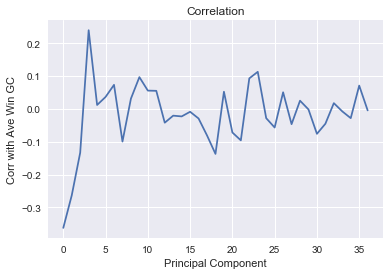

In [80]:
plt.plot(range(0, pca.components_.shape[0]), np.ndarray.flatten(corr_win_ave_gc_pc))
plt.title("Correlation")
plt.xlabel("Principal Component")
plt.ylabel("Corr with Ave Win GC")

In [91]:
# Copied from https://github.com/scikit-learn/scikit-learn/blob/a24c8b464d094d2c468a16ea9f8bf8d42d949f84/sklearn/utils/extmath.py
def svd_flip(u, v, u_based_decision=True):
    """Sign correction to ensure deterministic output from SVD.
    Adjusts the columns of u and the rows of v such that the loadings in the
    columns in u that are largest in absolute value are always positive.
    Parameters
    ----------
    u, v : ndarray
        u and v are the output of `linalg.svd` or
        `sklearn.utils.extmath.randomized_svd`, with matching inner dimensions
        so one can compute `np.dot(u * s, v)`.
    u_based_decision : boolean, (default=True)
        If True, use the columns of u as the basis for sign flipping.
        Otherwise, use the rows of v. The choice of which variable to base the
        decision on is generally algorithm dependent.
    Returns
    -------
    u_adjusted, v_adjusted : arrays with the same dimensions as the input.
    """
    if u_based_decision:
        # columns of u, rows of v
        max_abs_cols = np.argmax(np.abs(u), axis=0)
        signs = np.sign(u[max_abs_cols, range(u.shape[1])])
        u *= signs
        v *= signs[:, np.newaxis]
    else:
        # rows of v, columns of u
        max_abs_rows = np.argmax(np.abs(v), axis=1)
        signs = np.sign(v[range(v.shape[0]), max_abs_rows])
        u *= signs
        v *= signs[:, np.newaxis]
    return u, v

# From https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/decomposition/pca.py#L107
def svd(X):
    # Center data
    X_mean = np.mean(X, axis=0)
    X -= X_mean

    U, S, V = scipy.linalg.svd(X, full_matrices=False)
    # flip eigenvectors' sign to enforce deterministic output
    # See:  https://stackoverflow.com/questions/44765682/in-sklearn-decomposition-pca-why-are-components-negative
    # SVD is unique for the eigenvalues, but flipping the signs in the eigenvectors results in 
    # valid singular vectors as long as we flip signs for both U and V the same way.
    # In order to guarantee that the same eigenvectors are always returned, 
    # arbitrarily set the largest coefficient in U as positive.
    U, V = svd_flip(U, V)
    return U, S, V



def sample_contrib(X):
    """
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html
    @param X matrix:  rows = samples, cols = features
    @returns matrix:  rows = samples, cols = principal axes contributions to each sample.
    """
    # U:  cols are left singular vectors.  Ie rows are samples.  Cols are principal axes contributions to each sample.
    # V:  rows are left singular vectors.  Ie cols are features.  Rows are principal axes contributions to each feature.
    U, S, V = svd(X)
    
    # We want contribution of each sample onto each principal axis.
    # From U, rows are samples, cols are principal axes.
    # We want principal axis = linear combo of samples
    # 
    return U



In [108]:
# See https://github.com/cran/FactoMineR/blob/master/R/PCA.R
# Dimensions:  rows = samples, cols = principal axes
sample_loadings = sample_contrib(X=sample_win_depth_df)
display(sample_loadings.shape)
display(sample_loadings[:4, :4])

(37, 37)

array([[-0.11317341, -0.17291546,  0.07491815, -0.23900665],
       [-0.09047045, -0.04160363,  0.02241763,  0.05854138],
       [ 0.264252  , -0.15861296,  0.37745584,  0.36312244],
       [ 0.31566779, -0.03357655, -0.27500988,  0.04862982]])

In [102]:
# Find mean sample depth
ave_sample_depth = sample_loadings.mean(axis=1)
display(ave_sample_depth.shape)
display(ave_sample_depth[:3])

(37,)

array([ 0.01368648,  0.01401509,  0.0380725 ])

In [109]:
display(ave_sample_depth.shape)
display(sample_loadings.shape) 
# Find correlation of each sample contribution to principal axes vs sample depth
# We should end up with a correlation coefficient value for each of the 37 principal components.
# We need cols = principal axes.  rows = observations = sample contributions
corr_sample_ave_depth_pc = colcorr(A=sample_loadings, b=ave_sample_depth)
display(corr_sample_ave_depth_pc.shape)
display(corr_sample_ave_depth_pc)

(37,)

(37, 37)

(1, 37)

array([[ 0.16666667,  0.16666667,  0.16666667,  0.16666667,  0.16666667,
         0.16666667,  0.16666667,  0.16666667,  0.16666667,  0.16666667,
         0.16666667,  0.16666667,  0.16666667,  0.16666667,  0.16666667,
         0.16666667,  0.16666667,  0.16666667,  0.16666667,  0.16666667,
         0.16666667,  0.16666667,  0.16666667,  0.16666667,  0.16666667,
         0.16666667,  0.16666667,  0.16666667,  0.16666667,  0.16666667,
         0.16666667,  0.16666667,  0.16666667,  0.16666667,  0.16666667,
         0.16666667,  0.1638153 ]])

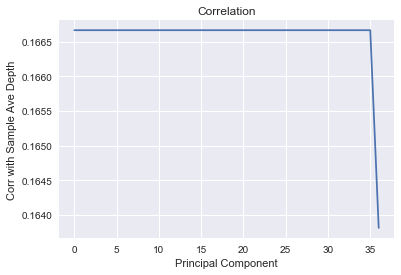

In [110]:
plt.plot(range(0, pca.components_.shape[0]), np.ndarray.flatten(corr_sample_ave_depth_pc))
plt.title("Correlation")
plt.xlabel("Principal Component")
plt.ylabel("Corr with Sample Ave Depth")